In [1]:
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats
from SiFoN import clinical_analysis as clin
from SiFoN import viz
import pandas as pd
import numpy as np
import re
%matplotlib inline

### Converting clinical data into a VCF format for Sei

As an example, we will be working with data from DOI: 10.1200/PO.17.00108 Suppl. Table 14. We will first load in the data and extract the information we want for future study

In [2]:
pten = pd.read_csv("test_input_data/brown_suppl4.csv")
pten.head(1)

,RefSeqID,Alteration,Protein Change,Classification,PromoterRegion,Breast Cancer Case Alleles,Breast Cancer Case MAF,Control Alleles,Control MAF,OR,95% CI 1,95% CI 2,Pvalue
0,NM_000314,c.-976G>C,NaN,VUS,Promoter,46,0.04%,40,0.08%,0.581,0.372,0.911,0.016


In [3]:
# Save any metadata you want for your analysis
pten = pten[["Alteration", "Breast Cancer Case Alleles", "Control Alleles", "Classification"]]
pten.head(2)

,Alteration,Breast Cancer Case Alleles,Control Alleles,Classification
0,c.-976G>C,46,40,VUS
1,c.-835C>T,14,10,VUS


At this point, you can save this metadata for future analysis. We still need to convert the `Alteration` column into an appropriate format for Sei. `cdot_to_VCF` converts alterations from the c-dot (c. pos ref > alt) format to a VCF file. This function expects a `chrm` paramter (since the chromosome name is not available in the c-dot format). If the positions are offset from a particular position, you can denote that with the `start` parameter. In this example, positions are relative to the A of the ATG start codon of the PTEN gene, which is at position 89,624,227 of chr10, so we set `start` to 89,624,227. The default of `start` is zero. Once you run this function, you can save this VCF and use it as input into Sei. 

In [4]:
pten_VCF = clin.cdot_to_VCF(pten, chrm="chr10", start=89624227)
pten_VCF.head(1)

,#CHROM,POS,ID,REF,ALT
0,chr10,89623251,c.-976G>C,G,C


There is also another function that will convert alterations in the following format "chrom_position_alt_ref"

### Load in Sei results and combine with metadata

In [5]:
row_labels = pd.read_csv("test_input_data/PTEN_row_labels", header=0) # Description of SNPs
print(len(row_labels))
row_labels.head(1)

203


,chrom,pos,Alteration,ref,alt,strand,ref_match,contains_unk
0,chr10,89623251,c.-976G>C,G,C,+,True,False


In [6]:
# Combine Sei/DeepSEA results with row labels that describe SNPs
scores = pd.read_csv("test_input_data/PTEN_sequence_class_scores.npy") # Sequence class scores
dis_score = pd.read_csv("test_input_data/PTEN_DIS.csv") # Disease impact score
scores["Disease Impact Score"] = dis_score["Disease Impact Score"]
scores["Alteration"] = row_labels["Alteration"]
scores.head(1) # see the last two columns

,PC1 Polycomb / Heterochromatin,L1 Low signal,TN1 Transcription,TN2 Transcription,L2 Low signal,E1 Stem cell,E2 Multi-tissue,E3 Brain / Melanocyte,L3 Low signal,E4 Multi-tissue,...,HET4 Heterochromatin,L7 Low signal,PC4 Polycomb / Bivalent stem cell Enh,HET5 Centromere,E11 T-cell,TF5 AR,E12 Erythroblast-like,HET6 Centromere,Disease Impact Score,Alteration
0,0.036797,0.016578,0.015117,0.015232,0.010343,0.024441,0.021501,0.035103,0.033337,0.092842,...,0.002037,0.009142,0.025761,0.021403,0.089531,0.025894,0.009224,0.00617,-0.310427,c.-976G>C


In [7]:
# Combine clinical data with SNP IDs and Sei results
clinical_data = pd.read_csv("test_input_data/PTEN_Brown_Suppl4.csv")
scores = clinical_data.merge(scores) # Clinical data connects to the Sei results by the `Alteration` column.
scores.head(1)

,Alteration,Breast Cancer Case Alleles,Control Alleles,Classification,PC1 Polycomb / Heterochromatin,L1 Low signal,TN1 Transcription,TN2 Transcription,L2 Low signal,E1 Stem cell,...,TF4 OTX2,HET4 Heterochromatin,L7 Low signal,PC4 Polycomb / Bivalent stem cell Enh,HET5 Centromere,E11 T-cell,TF5 AR,E12 Erythroblast-like,HET6 Centromere,Disease Impact Score
0,c.-976G>C,46,40,VUS,0.036797,0.016578,0.015117,0.015232,0.010343,0.024441,...,0.017301,0.002037,0.009142,0.025761,0.021403,0.089531,0.025894,0.009224,0.00617,-0.310427


We can also calculate odds ratios (OR) for SNPs based on their case and control counts. we can then assign SNPs as case or control SNPs based on their odds ratios. It is important to remember that some SNPs might be very rare (e.g. only occuring in a single indidivual). Even though these SNPs might not have high OR, they might still have a functional impact. 

The `odds_ratio` function will add a column `Odds Ratio` to your data frame.

The `add_case_control_label` function will assign case/control labels based on OR cutoffs that you determine. This will show up in the `Case/Control` column.

In [8]:
clin.odds_ratio(df=scores, control_col="Control Alleles", case_col = "Breast Cancer Case Alleles",
               num_cases = 52065, num_controls = 28549, correction = 0.1)
clin.add_case_control_label(df=scores, case_cuttoff = 1.5, control_cutoff = 0.5)
scores.head(1) # see the last two columns

,Alteration,Breast Cancer Case Alleles,Control Alleles,Classification,PC1 Polycomb / Heterochromatin,L1 Low signal,TN1 Transcription,TN2 Transcription,L2 Low signal,E1 Stem cell,...,L7 Low signal,PC4 Polycomb / Bivalent stem cell Enh,HET5 Centromere,E11 T-cell,TF5 AR,E12 Erythroblast-like,HET6 Centromere,Disease Impact Score,Odds Ratio,Case/Control
0,c.-976G>C,46,40,VUS,0.036797,0.016578,0.015117,0.015232,0.010343,0.024441,...,0.009142,0.025761,0.021403,0.089531,0.025894,0.009224,0.00617,-0.310427,0.476967,Control


You might want to perform T-tests to see whether a particular Sei/DeepSEA measure is significantly different between cases and controls. You can do this using the below code. Change `y` to any Sei prediction name/column to run a t-test.

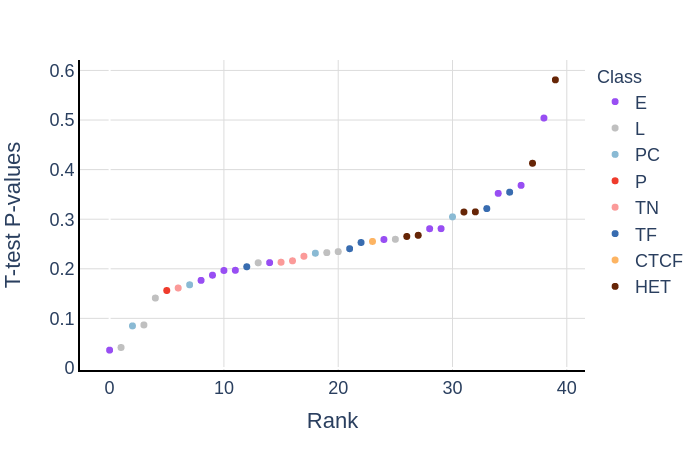

In [9]:
# In this example, we take only the cases that have a single case or a single control.
counts = [sum(x) for x in zip(scores["Control Alleles"].values,  scores["Breast Cancer Case Alleles"].values)]
ttest_df = clin.seq_class_t_tests(scores[[count == 1 for count in counts]], 
                                  filename="test_output_plots/PTEN_t_test.html", fontsize=18)

In [10]:
ttest_df.head(3)

,Sequence Class,P-value,Class,Color,Rank
12,E5 B-cell-like,0.036009,E,#984ef3,0
22,L5 Low signal,0.041325,L,#C0C0C0,1
34,PC4 Polycomb / Bivalent stem cell Enh,0.084857,PC,#8abad4,2


You can also plot different scores to identify SNPs that have high scores across different sequence classes. The Disease Impact Score is a useful score to analyze. Having a high sequence class score and a high DIS might suggest that a particular mutation is functionally important. In the below plot, each point represents a SNP. You can hover over points to gather meta data about the SNP, including the alteration ID and the number of case and control counts.

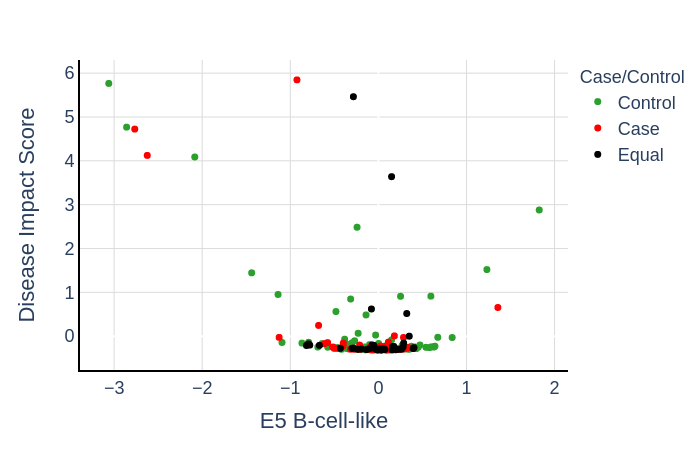

In [11]:
score1, score2 = "E5 B-cell-like", "Disease Impact Score"
color = "Case/Control" # if this is changed, the `color_discrete_sequence` will have to be changed or removed
fig = px.scatter(scores, x=score1, y=score2, color=color,
                   hover_data=['Alteration', 'Breast Cancer Case Alleles', 'Control Alleles', score1, score2], 
                     color_discrete_sequence=['#2ca02c', "red", "black"])
fig.update_layout(font=dict(size=18))
fig.update_traces(marker={'size': 7})
viz.white_bg(fig)
fig.write_html("test_output_plots/" + score1 + "_v_" + score2 + ".html")
fig.show("png")

You can also label points that are above a certain threshold.

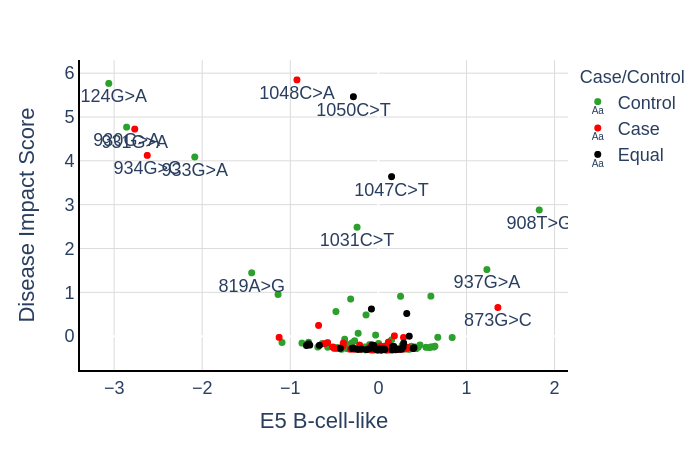

In [12]:
score1, score2 = "E5 B-cell-like", "Disease Impact Score"
color = "Case/Control" # if this is changed, the `color_discrete_sequence` will have to be changed or removed
cutoff1, cutoff2 = 1, 1.13
high_impact = [score_1 > cutoff1 or abs(score_2) > cutoff2  for score_1, score_2 in zip(scores[score1], scores[score2])]
scores["Text Labels"] = [alt[3:] if HI else "" for HI, alt in zip(high_impact, scores["Alteration"])]

fig = px.scatter(scores, x=score1, y=score2, color=color,
                   hover_data=['Alteration', 'Breast Cancer Case Alleles', 'Control Alleles', score1, score2], 
                    color_discrete_sequence=['#2ca02c', "red", "black"],
                                         text="Text Labels")
fig.update_traces(textposition='bottom center')
fig.update_layout(font=dict(size=18))
fig.update_traces(marker={'size': 7})
viz.white_bg(fig)
fig.write_html("test_output_plots/" + score1 + "_v_" + score2 + ".html")
fig.show("png")

### Using the `viz` library, we can also calculate the maximum score in this data and combine this information with our clinical data

In [13]:
scores = pd.read_csv("test_input_data/PTEN_sequence_class_scores.npy")
max_scores = viz.find_max(scores, signed=True).drop(columns="index")
max_scores.head(1)

,Max Score,Sequence Name,Sequence Index,Class,Color,Function
0,0.120863,E5 B-cell-like,12,E,#984ef3,Active


Again, we will join all the data together.

In [14]:
max_scores["Disease Impact Score"] = dis_score["Disease Impact Score"]
max_scores["Alteration"] = row_labels["Alteration"]
max_scores = clinical_data.merge(max_scores)
clin.odds_ratio(df=max_scores, control_col="Control Alleles", case_col = "Breast Cancer Case Alleles",
               num_cases = 52065, num_controls = 28549, correction = 0.1)
clin.add_case_control_label(df=max_scores, case_cuttoff = 1.5, control_cutoff = 0.5)
max_scores.head(1)

,Alteration,Breast Cancer Case Alleles,Control Alleles,Classification,Max Score,Sequence Name,Sequence Index,Class,Color,Function,Disease Impact Score,Odds Ratio,Case/Control
0,c.-976G>C,46,40,VUS,0.120863,E5 B-cell-like,12,E,#984ef3,Active,-0.310427,0.476967,Control


In [15]:
max_scores.head(3)

,Alteration,Breast Cancer Case Alleles,Control Alleles,Classification,Max Score,Sequence Name,Sequence Index,Class,Color,Function,Disease Impact Score,Odds Ratio,Case/Control
0,c.-976G>C,46,40,VUS,0.120863,E5 B-cell-like,12,E,#984ef3,Active,-0.310427,0.476967,Control
1,c.-835C>T,14,10,VUS,-0.338331,P Promoter,25,P,#ef3b2c,Active,-0.305452,0.392778,Control
2,c.-931G>A,0,1,VUS,-2.766029,E5 B-cell-like,12,E,#984ef3,Active,4.723788,6.031672,Case


We can also plot the DIS across genomic positions, to see if there are any short subsequences that have particularly high scores. In this case, we see two regions that have a few SNPs with particularly high Enhancer and CTCF scores.

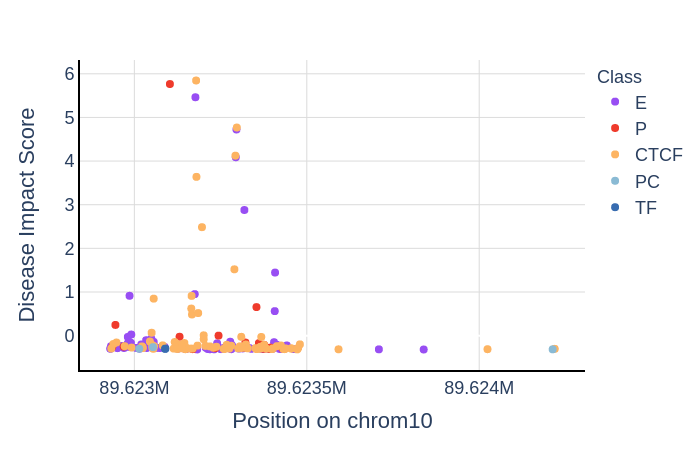

In [16]:
max_scores["Position on chrom10"] = row_labels["pos"]

fig = px.scatter(max_scores, x="Position on chrom10", y="Disease Impact Score", color="Class", 
                 color_discrete_sequence = max_scores["Color"].unique(), hover_data=max_scores.columns)
viz.white_bg(fig)
fig.update_traces(marker={'size': 8})
fig.update_layout(font=dict(size=18))
fig.write_html("test_output_plots/DIS_v_position.html")
fig.show("png")